# Developing a Regression Model to Predict the Gold Recovery for a Digital Solution Provider

# Contents <a id='back'></a>
* [1. Introduction](#intro)
* [2. Data Exploration](#data_exploration)
* [3. Data Preprocessing](#data_preprocessing)
    * [3.1 Checking the Values of Targets](#check_targets)
    * [3.2 Analysing the Features Not Available in the Test Data](#analyse_diff_features)
    * [3.3 Missing Values](#missing_values)
* [4. Exploratory Data Analysis (EDA)](#eda)
    * [4.1 Concentrations of Metals in Different Stages](#metal_concentration)
    * [4.2 The Distributions of the Feed Particle Size in The Training and Test Datasets](#particle_distribution)
    * [4.3 Distributions of the Total Concentration of Metals at Different Stages](#total_concentration)
    * [4.4 Distributions of the Target Data](#target_distribution)
* [5. Development of Models](#models)
    * [5.1 Separate the Data into Features and Targets](#feature_target)
    * [5.2 Feature Selection](#feature_selection)
    * [5.3 Feature Scaling](#feature_scaling)
    * [5.4 Training Different Models](#train_models)
    * [5.5 Fine-tuning Selected Models](#fine_tune_models)
    * [5.6 Evaluation of the Final Model on the Test Set](#final_model)
* [6. General Conclusion](#general_conclusion)
* [7. Appendix](#appendix)

## 1. Introduction <a id='intro'></a>
Zyfra is a digital solution provider which improve the efficiency and safety of the mining, oil & gas, chemical and engineering industries. This project aims to build a machine learning model for Zyfra to predict the gold recovery.

### Purpose
To develop a regression model which predicts the gold recovery by using the data gathered at different stages of the gold extraction process.

In [1]:
# For data preprocessing and manipulation
import pandas as pd
import numpy as np
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Machine Learning Models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor

# Model Evaluation and Selection
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
import optuna
from optuna.samplers import TPESampler

pd.set_option('display.max_columns', None)

## 2. Data Exploration <a id='data_exploration'></a>

Before loading the datasets, lets' have a look at the graph below which shows the overall process of gold extraction.

![gold_extraction_process](https://raw.githubusercontent.com/chongwee0312/tripleten_datascience_projects/main/project_09/images/gold_extraction_process.jpg)

The whole gold extraction process can be briefly described in three stages. The first stage is to process the mined ore and get the ore mixutre (rougher feed). The second stage is the floatation stage which add specific checimal reagents to separate the gold particles from the other substances and obtain rougher Au concentrate and rougher tails (product residues with a low concentration of valuable metals). The third stage is the purification stage which further refine and purify the gold in the rougher concentrate and produce the final Au concentrate.

**Terminology**
- Rougher feed — raw material
- Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
- Xanthate — promoter or flotation activator
- Sulphate — sodium sulphide for this particular process
- Depressant — sodium silicate
- Rougher process — flotation
- Rougher tails — product residues
- Float banks — flotation unit
- Cleaner process — purification
- Rougher Au — rougher gold concentrate
- Final Au — final gold concentrate

In [2]:
# Create a dictianary to store 3 datasets
data = {}

# Create two lists containing the key names and paths
datasets = ['full', 'train', 'test']
paths = ['gold_recovery_full.csv', 'gold_recovery_train.csv', 'gold_recovery_test.csv']

# Use a for loop to load the datasets and store in the dictionary
for i, dataset in enumerate(datasets):
    try:
        data[dataset] = pd.read_csv(paths[i])
    except:
        data[dataset] = pd.read_csv(f'/datasets/{paths[i]}')

In [3]:
# Have a look at the first 3 rows of each dataset
for dataset in datasets:
    print('\033[1m')
    print('*' * 25)
    print(f'{dataset} data')
    print('Number of rows:', data[dataset].shape[0])
    print('Number of columns:', data[dataset].shape[1])
    print('*' * 25)
    display(data[dataset].head(3))


*************************
full data
Number of rows: 22716
Number of columns: 87
*************************


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


*************************
train data
Number of rows: 16860
Number of columns: 87
*************************


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.


*************************
test data
Number of rows: 5856
Number of columns: 53
*************************


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


As informed by the company Zyfra, the `full data` is separated into the `train data` and the `test data`. Therefore, the number of rows in the `full date` (22716) is the total number of rows in `train data` (16860) and `test data` (5856). Each row represents one complete process of gold extraction. The `full data` and the `test data` have 87 columns while the `test data` has 53 columns.

In [4]:
# Have a look at all the columns in the full_data and train_data
for column in data['full'].columns:
    print(column)

date
final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.input.sulfate
primary_cleaner.input.depressant
primary_cleaner.input.feed_size
primary_cleaner.input.xanthate
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
primary_cleaner.state.floatbank8_a_air
primary_cleaner.state.floatbank8_a_level
primary_cleaner.state.floatbank8_b_air
primary_cleaner.state.floatbank8_b_level
primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_c_level
primary_cleaner.state.floatbank8_d_air
primary_cleaner.state.floatbank8_d_level
rougher.calculation.sulfate_to_au_concentrate
rough

**Description of data**
- date: exact datetime value of the gold extraction process to be carried out

Other columns are named with the format *[stage].[parameter_type].[parameter_name]*

*Possible values for [stage]*
- rougher: flotation
- primary_cleaner: primary purification
- secondary_cleaner: secondary purification
- final: final characteristics

*Possible values for [parameter_type]*
- input: raw material parameters
- output: product parameters
- state: parameters characterising the current state of the stage
- calculation: calculation characteristics

*Possible values for [parameter_name]*
- _air: volume of air
- _level: fluid level
- feed_size: size of the feed particle
- feed_rate: feeding speed
- concentrate_: percentage of the substance in the concentrate
- tail_: percentage of the substance in the rougher tails
- recovery - gold recovery in percentage

**Targets**

- **rougher.output.recovery**
- **final.output.recovery**

In [5]:
# Check for duplicates
for dataset in datasets:
    print('\033[1m')
    print(f'Number of duplicates in {dataset} data: ', end='')
    print(data[dataset].duplicated().sum())


Number of duplicates in full data: 0

Number of duplicates in train data: 0

Number of duplicates in test data: 0


In [6]:
# To show the data types of all columns
pd.set_option('display.max_rows', None)

# Check for data types
for dataset in datasets:
    print('\033[1m', f'{dataset} data', '\033[0m')
    display(data[dataset].dtypes)

# Reset the max_rows option
pd.reset_option('display.max_rows')

 full data 


date                                                   object
final.output.concentrate_ag                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.concentrate_au                           float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
final.output.tail_au                                  float64
primary_cleaner.input.sulfate                         float64
primary_cleaner.input.depressant                      float64
primary_cleaner.input.feed_size                       float64
primary_cleaner.input.xanthate                        float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_

 train data 


date                                                   object
final.output.concentrate_ag                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.concentrate_au                           float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
final.output.tail_au                                  float64
primary_cleaner.input.sulfate                         float64
primary_cleaner.input.depressant                      float64
primary_cleaner.input.feed_size                       float64
primary_cleaner.input.xanthate                        float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_

 test data 


date                                           object
primary_cleaner.input.sulfate                 float64
primary_cleaner.input.depressant              float64
primary_cleaner.input.feed_size               float64
primary_cleaner.input.xanthate                float64
primary_cleaner.state.floatbank8_a_air        float64
primary_cleaner.state.floatbank8_a_level      float64
primary_cleaner.state.floatbank8_b_air        float64
primary_cleaner.state.floatbank8_b_level      float64
primary_cleaner.state.floatbank8_c_air        float64
primary_cleaner.state.floatbank8_c_level      float64
primary_cleaner.state.floatbank8_d_air        float64
primary_cleaner.state.floatbank8_d_level      float64
rougher.input.feed_ag                         float64
rougher.input.feed_pb                         float64
rougher.input.feed_rate                       float64
rougher.input.feed_size                       float64
rougher.input.feed_sol                        float64
rougher.input.feed_au       

All the data types are correct except the `date` column.

**Issue needs to be addresed**
- Change the data type of `date` to datetime.

In [7]:
# Check the number of missing values
# Show the top 20 columns with the most number of missing values
for dataset in datasets:
    print('\033[1m', f'Missing values in {dataset} data', '\033[0m')
    display(data[dataset].isna().sum().nlargest(20))

 Missing values in full data 


rougher.output.recovery                   3119
rougher.output.tail_ag                    2737
rougher.output.tail_sol                   2736
rougher.output.tail_au                    2736
rougher.input.floatbank11_xanthate        2257
secondary_cleaner.output.tail_sol         2215
final.output.recovery                     1963
rougher.calculation.au_pb_ratio           1627
primary_cleaner.input.sulfate             1609
primary_cleaner.input.depressant          1546
rougher.input.floatbank10_sulfate         1301
primary_cleaner.input.xanthate            1151
primary_cleaner.output.concentrate_sol     798
rougher.input.floatbank11_sulfate          678
rougher.state.floatbank10_e_air            620
rougher.input.feed_rate                    553
rougher.input.floatbank10_xanthate         469
primary_cleaner.output.concentrate_pb      448
rougher.input.feed_size                    439
final.output.concentrate_sol               385
dtype: int64

 Missing values in train data 


rougher.output.recovery                     2573
rougher.output.tail_ag                      2250
rougher.output.tail_sol                     2249
rougher.output.tail_au                      2249
secondary_cleaner.output.tail_sol           1986
rougher.input.floatbank11_xanthate          1904
final.output.recovery                       1521
primary_cleaner.input.sulfate               1307
primary_cleaner.input.depressant            1262
rougher.calculation.au_pb_ratio             1242
rougher.input.floatbank10_sulfate           1044
primary_cleaner.input.xanthate               985
primary_cleaner.output.concentrate_sol       636
rougher.input.floatbank11_sulfate            623
rougher.state.floatbank10_e_air              603
rougher.input.feed_rate                      513
rougher.input.feed_size                      417
final.output.concentrate_sol                 370
secondary_cleaner.state.floatbank2_a_air     363
primary_cleaner.output.concentrate_pb        358
dtype: int64

 Missing values in test data 


rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary_cleaner.state.floatbank3_a_air     34
secondary_cleaner.state.floatbank2_b_air     23
rougher.input.feed_size                      22
secondary_cleaner.state.floatbank2_a_air     20
rougher.state.floatbank10_a_air              17
rougher.state.floatbank10_b_air              17
rougher.state.floatbank10_c_air              17
rougher.state.floatbank10_d_air              17
rougher.state.floatbank10_e_air              17
rougher.state.floatbank10_f_air              17
primary_cleaner.state.floatbank8_a_air       16
dtype: int64

**Issue needs to be addressed**
- There are plenty of missing values in the three datasets. These missing values, especially the targets `rougher.output.recovery` and the `final.output.recovery`, will be further investigated in the data preprocessing stage.

Next, we will have a check on the descriptive statictis of the numerical columns. Since the `train data` and the `test data` originated from the `full data`, we will only check the descriptive statistics of `full data`. These numerical columns will be categorised into three groups and investigated separately.

In [8]:
# Create a column list consists of input data
input_columns = []
for column in data['full'].columns:
    if 'input' in column:
        input_columns.append(column)
        
# Create a column list consists of output data
output_columns = []
for column in data['full'].columns:
    if 'output' in column:
        output_columns.append(column)

# The remaining columns
other_columns = []
for column in data['full'].columns:
    if column not in input_columns and column not in output_columns:
        other_columns.append(column)

In [9]:
# Check the descriptive statistics of input_columns
data['full'][input_columns].describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate
count,21107.000000,21170.000000,22716.000000,21565.000000,22618.000000,22472.000000,22163.000000,22277.000000,22357.000000,22617.000000,21415.000000,22247.000000,22038.000000,20459.000000
mean,140.277672,8.587607,7.288872,0.969830,8.065715,3.305676,441.873650,57.959166,33.276016,7.565838,11.784263,5.573526,11.209718,5.962586
std,49.919004,3.611361,0.617357,0.548083,3.125250,1.446905,156.736078,23.644823,11.494135,3.026954,4.093125,1.908123,4.685205,1.280682
min,0.000003,0.000000,1.080000,0.000003,0.000000,0.000000,0.000044,0.046369,0.000000,0.000000,0.000002,0.000003,0.000014,0.000010
25%,110.177081,6.018085,6.920000,0.626346,6.944415,2.658814,398.222097,46.687088,32.524264,6.485009,9.915698,5.046782,9.281388,5.353321
50%,141.330501,8.018173,7.280000,0.905286,8.302613,3.432054,488.968597,53.405122,36.559955,7.884832,11.998801,5.999078,11.946466,6.034551
75%,174.049914,11.003573,7.680000,1.200734,10.135202,4.204960,546.587401,64.096151,39.675470,9.668064,14.437582,6.700493,14.015696,6.799526
max,274.409626,40.024582,15.500000,6.027907,14.869652,7.142594,717.508837,484.967466,53.477742,14.093363,36.118275,31.493331,37.980648,18.709478


**Issue needs to be addressed**
- There are some anomalies of `0` values in the `feed` columns. These anomalies could be a reason causing the missing values in `rougher.output.recovery` and `final.output.recovery` since it is impossible to have any recovered gold without any input.

In [10]:
# Check the descriptive statistics of output_columns
data['full'][output_columns].describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,22618.000000,22268.000000,21918.000000,22618.000000,22614.000000,22594.000000,22365.000000,22617.000000,22618.000000,22618.000000,22526.000000,22618.000000,19597.000000,19979.000000,22618.000000,19980.000000,19980.000000,22616.000000,22600.000000,20501.000000,22618.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,7.691652,8.921110,9.573672,29.212289,14.876219,3.175822,7.208474,3.670333,10.874484,6.900646,26.095508,17.879538,83.078122,5.587861,0.593620,18.040138,1.821193,13.375349,5.304107,6.465460,4.041218
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,3.109306,3.706314,4.788433,10.539303,5.654342,1.652177,3.087892,1.985206,4.377924,2.806948,10.140120,6.790112,14.661880,1.114614,0.315295,3.470514,0.695663,5.768719,3.092536,4.277993,2.605738
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.594562,0.000000,10.014648,0.020676,0.000000,0.000000,0.000000,0.000000
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,6.771102,7.834690,7.009980,29.374406,13.464756,2.269103,5.961535,2.741534,10.126646,6.374692,25.815139,17.928729,80.941306,4.887758,0.427513,15.788283,1.403951,11.802936,3.451435,2.658971,2.877554
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,8.265643,9.921116,9.851136,32.359813,15.600454,3.154022,7.873945,3.513008,11.785127,7.572855,29.382638,20.003202,86.144121,5.759630,0.590746,18.082595,1.808567,15.222165,5.074145,6.966645,3.956171
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,9.697896,11.266100,13.180304,34.770726,17.931084,4.123574,9.348743,4.559485,13.615299,8.477358,32.002766,21.564238,89.987561,6.386301,0.763219,20.084427,2.215317,17.231611,7.585281,10.152612,5.006944
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,16.081632,17.081278,22.458114,45.933934,29.459575,9.634565,22.276364,18.528821,24.480271,18.394042,40.089993,28.824507,100.000000,12.719177,3.778064,66.117188,9.688980,23.264738,17.042505,33.058594,26.811643


**Issue needs to be adderesed**
- Most of the `output` columns have minimum values of `0` which are regarded as anomalies.

In [11]:
# Check the descriptive statistics of the remaining columns
data['train'][other_columns].describe()

,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16820.000000,16827.000000,16820.000000,16833.000000,16822.000000,16833.000000,16821.000000,16833.000000,1.683300e+04,1.683300e+04,1.683300e+04,15618.000000,16807.000000,16807.000000,16807.000000,16807.000000,16807.000000,16814.000000,16802.000000,16809.000000,16257.000000,16809.000000,16802.000000,16802.000000,16497.000000,16751.000000,16705.000000,16748.000000,16763.000000,16747.000000,16752.000000,16750.000000,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,1521.291691,-505.811103,1523.880015,-507.346105,1514.351131,-507.094373,1468.599116,-501.835392,-1.137202e+04,3.784836e+03,2.017512e+03,2.327953,1077.201302,-384.109359,1252.285954,-475.443395,1229.567445,-474.713811,1146.785992,-476.180417,1033.886871,-475.545309,983.384202,-475.980531,28.134535,-517.777116,23.619503,-519.562134,27.913358,-493.470026,21.663507,-501.521561,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,380.064453,77.640285,381.245324,79.830738,396.493106,78.823157,444.329353,87.257010,5.754320e+06,7.088720e+04,4.836941e+04,0.899125,291.800894,112.408685,331.076715,70.051458,344.840251,67.065122,327.311834,64.118377,293.456164,68.781915,275.426261,70.132801,8.320744,89.551883,8.144236,89.374849,8.170477,85.296428,6.738952,74.723250,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,-800.037388,0.000000,-800.409770,0.000000,-800.362914,0.000000,-800.166222,-6.643891e+08,-2.023459e+06,-4.014502e+06,-0.010548,-0.345168,-658.223080,-0.759568,-650.437575,-0.378521,-650.151190,-1.197435,-649.300693,-2.163619,-650.196204,-2.636171,-650.072915,0.000000,-799.841677,0.000000,-799.967956,0.000000,-799.926254,0.000000,-809.421923,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,1503.883158,-500.414946,1502.956269,-500.491143,1500.685486,-500.859360,1418.756530,-500.643616,3.898865e+04,2.502308e+03,2.498158e+03,1.979046,999.636979,-499.908427,1196.415722,-500.284895,1100.084257,-500.329171,1044.848978,-500.594910,949.615568,-500.395113,900.029475,-500.738649,25.045244,-500.333800,20.110141,-500.348178,24.972364,-500.236661,19.007706,-500.141064,14.508299,-500.837689,10.741388

There are no obvious anomalies except some `0` values. These `0` values are not considered as anomalies since negative values also present in these columns.

**Issue needs to be addressed**
- Since the range of values are of different scales, standardisation will be performed as it can improve the convergence speed of the model which utilise gradient descent to optimise the cost function. Besides that, standardisation is necessary for distance-based algorithms.

**Conclusion**

1. The `full data` of 22716 rows is separated into `train data` (16860 rows) and `test data` (5856 rows). The `test data` has less columns than the `full data` and the `train data`.
2. The data type of `date` in the three datasets are incorrect and needs to be converted to datetime.
3. The large amount of missing values will be investigated. The missing values in the targets `rougher.output.recovery` and `final.output.recovery` could be ralated to the anomalies of `0` in the `input` and `output` columns.
4. The standardisation will be carried out since the range of values of the features are of different scales.

[Back to Contents](#back)

## 3. Data Preprocessing <a id='data_preprocessing'></a>

In [12]:
# Convert the data type of date column to datetime
date_format = '%Y-%m-%d %H:%M:%S'

for dataset in datasets:
    data[dataset]['date'] = pd.to_datetime(data[dataset]['date'], format=date_format)
    
    # Check if the conversion has been made
    display(data[dataset]['date'].head(3))

0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
Name: date, dtype: datetime64[ns]

0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
Name: date, dtype: datetime64[ns]

0   2016-09-01 00:59:59
1   2016-09-01 01:59:59
2   2016-09-01 02:59:59
Name: date, dtype: datetime64[ns]

[Back to Contents](#back)

### 3.1 Checking the Values of Targets <a id='check_targets'></a>

In the data exploration stage, it has been known that the targets `rougher.output.recovery` and `final.output.recovery` have many missing values. Since the data was downloaded from the warehouse, we will recalculate the values of these two targets to verify if the data is correct before building the model.

To calculate the gold recovery, we make use of the mass balanced equations,

$$\begin{align*}
F &= C + T \tag{1} \\
Ff &= Cc + Tt \tag{2}
\end{align*}$$

where

$$\begin{align*}
&F \text{: weight of the feed} &&f \text{: concentration of Au in the feed} \\
&C \text{: weight of the concentrate} &&c \text{: concentration of Au in the concentrate} \\
&T \text{: weight of the tailings} &&t \text{: concentration of Au in the tailings} \\
\end{align*}$$

the gold recovery is calculated by

$$\begin{align*}
\text{Recovery} &= \frac{Cc}{Ff} \times 100\% \tag{3}
\end{align*}$$

Since we only have the values of *f* (`rougher.input.feed_au`), *c* (`rougher.output.concentrate_au`) and *t* (`rougher.output.tail_au`), the variables *C*, *F* and *T* can be eliminated from equations (1), (2) and (3) and we have

$$\begin{align*}
\text{Recovery} &= \frac{c (f - t)}{f (c - t)} \times 100\% \tag{4}
\end{align*}$$

In [13]:
# Calculate the rougher recovery
f_r = data['train']['rougher.input.feed_au']
c_r = data['train']['rougher.output.concentrate_au']
t_r = data['train']['rougher.output.tail_au']

data['train']['check_rougher_recovery'] = (c_r * (f_r - t_r)) / (f_r * (c_r - t_r)) * 100

# Have a look at the original and calculated values
display(data['train'][['rougher.output.recovery', 'check_rougher_recovery']])

,rougher.output.recovery,check_rougher_recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
16855,89.574376,89.574376
16856,87.724007,87.724007
16857,88.890579,88.890579
16858,89.858126,89.858126


From the table above, it seems like the values provided by the company are correct, we can further confirm this by calculating the mean absolute error. However, there are a lot of missing values in the original data, let's check the number of non-missing values in this columns before calculating the mean absolute error.

In [14]:
# Compare the amounts of non-missing values
print('Total number of original values: ', end='')
print(data['train']['rougher.output.recovery'].count())

print('Total Number of calculated values: ', end='')
print(data['train']['check_rougher_recovery'].count())

Total number of original values: 14287
Total Number of calculated values: 14577


There are 290 more values than the original data. Let's have a check.

In [15]:
data['train']['check_rougher_recovery'].describe()

count    1.457700e+04
mean              NaN
std               NaN
min              -inf
25%      7.965104e+01
50%      8.521533e+01
75%      9.019726e+01
max               inf
Name: check_rougher_recovery, dtype: float64

There are some anomalies of infinite values, we can verity if the total of anomalies is equal to 290.

In [16]:
data['train'][
    (data['train']['check_rougher_recovery'] < 0) | (data['train']['check_rougher_recovery'] > 100)
].shape[0]

290

Indeed, there are a total of 290 values which lie outside of the normal range of 0 to 100. We will calculate the mean absolute errors with the remaining 14287 values.

In [17]:
# Check the mean absolute error between the original and calculate rougher recovery
rougher_recovery_mae = np.mean(np.abs(
    data['train']['rougher.output.recovery'] - data['train']['check_rougher_recovery']
))
print('The mean absolute error of rougher recovery:', rougher_recovery_mae)

The mean absolute error of rougher recovery: 9.303415616264301e-15


The mean absolute error of 9.30 e-15 is negligible, this shows that the `rougher.output.recovery` values are correct and can be used to train the machine learning models.

In [18]:
# Have a quick check on the final recovery values
f_f = data['train']['rougher.input.feed_au']
c_f = data['train']['final.output.concentrate_au']
t_f = data['train']['final.output.tail_au']

data['train']['check_final_recovery'] = (c_f * (f_f - t_f)) / (f_f * (c_f - t_f)) * 100

display(data['train'][['final.output.recovery', 'check_final_recovery']])

final_recovery_mae = np.mean(np.abs(
    data['train']['final.output.recovery'] - data['train']['check_final_recovery']
))
print('The mean absolute error of final recovery:', final_recovery_mae)

,final.output.recovery,check_final_recovery
0,70.541216,70.541216
1,69.266198,69.266198
2,68.116445,68.116445
3,68.347543,68.347543
4,66.927016,66.927016
...,...,...
16855,73.755150,73.755150
16856,69.049291,69.049291
16857,67.002189,67.002189
16858,65.523246,65.523246


The mean absolute error of final recovery: 7.974449743579576e-15


The values in the `final.output.recovery` are also correct.

[Back to Contents](#back)

In [19]:
# Drop the two checking columns
data['train'].drop(columns=['check_rougher_recovery', 'check_final_recovery'], inplace=True)

### 3.2 Analysing the Features Not Available in the Test Data <a id='analyse_diff_features'></a>

In the data exploration stage, it has been found that the `test data` has less number of columns than the `full data` and the `train data`, we will analyse the nature of these columns.

In [20]:
# Find the columns which are not included in the test data
diff_columns = list(set(data['train'].columns).difference(set(data['test'].columns)))

# Print the columns
for column in diff_columns:
    print(column)
print(f'\nThe test data has {len(diff_columns)} less columns than the full and train data')

rougher.output.tail_sol
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.output.tail_pb
rougher.output.recovery
secondary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
secondary_cleaner.output.tail_sol
rougher.output.concentrate_pb
final.output.concentrate_ag
rougher.output.concentrate_au
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_ag
final.output.recovery
final.output.concentrate_au
final.output.tail_au
primary_cleaner.output.tail_sol
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.calculation.sulfate_to_au_concentrate
final.output.tail_ag
final.output.concentrate_pb
final.output.tail_sol
final.output.concentrate_sol
primary_cleaner.output.tail_ag
rougher.output.tail_ag
rougher.output.tail_au
secondary_cleaner.output.tail_pb
rougher.output.concentrate_sol
primary_cleaner.output.tail_au
secondary_cleaner.output.tail_au
rougher.calculation.floatbank11_sulfate_to_au_feed
final.output.tail_pb
primary_cleaner.output.conce

From the list above, the features (columns) are related to the measurement or calculations after the gold extraction process. These columns (except the two targets `rougher.output.recovery` and `final.output.recovery`) will be dropped from the `train data` as the prediction should be made based on the features during the gold extraction process. It will be pointless to predict the recovery if we have the values from these columns as we can calculate the target values easily.

[Back to Contents](#back)

### 3.3 Missing Values <a id='missing_values'></a>

It is not possible to train a supervised machine learning model without a target, thus the rows with missing values in `rougher.output.recovery` and `final.output.recovery` will be dropped.

In [21]:
# Find the % of missing values of rougher recovery and final recovery in train data
data['train'][['rougher.output.recovery', 'final.output.recovery']].isna().mean()

rougher.output.recovery    0.152610
final.output.recovery      0.090214
dtype: float64

In [22]:
# Drop the missing values of rougher recovery and final recovery in train data
data['train'].dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

# Check if the missing values have been dropped
data['train'][['rougher.output.recovery', 'final.output.recovery']].isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

In [23]:
# Merge test data with target values
data['test'] = data['test'].merge(
    data['full'][['date', 'rougher.output.recovery', 'final.output.recovery']],
    on = 'date'
)

In [24]:
# Check the target columns in the test data
data['test'][['rougher.output.recovery', 'final.output.recovery']].head()

,rougher.output.recovery,final.output.recovery
0,89.993421,70.273583
1,88.089657,68.910432
2,88.412756,68.143213
3,87.360133,67.776393
4,83.236367,61.467078


In [25]:
# Find the % of missing values of rougher recovery and final recovery in test data
data['test'][['rougher.output.recovery', 'final.output.recovery']].isna().mean()

rougher.output.recovery    0.093238
final.output.recovery      0.075478
dtype: float64

In [26]:
# Drop the missing values of rougher recovery and final recovery in test data
data['test'].dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

# Check if the missing values have been dropped
data['test'][['rougher.output.recovery', 'final.output.recovery']].isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

In [27]:
# Check the remaining missing values in train data
data['train'].isna().sum().nlargest(10)

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
final.output.concentrate_sol                 211
rougher.input.feed_size                      144
final.output.tail_pb                         100
primary_cleaner.input.xanthate               100
rougher.input.feed_pb                        100
dtype: int64

The column with the highest number of missing values is `secondary_cleaner.output.tail.sol` which is a calculation (or measurement) column after the gold extraction process. These missing values from the calculation columns is likely due to human error since they are mearusred and/or calculated much later. These missing values can be ignored since the calculation columns will be dropped before training the models.

Excluding the calculation columns, let's have a look at the other columns.

In [28]:
# Check the percentage of missing values in each non-calculation / measurement column
data['train'][data['test'].columns].isna().mean().nlargest(10)

rougher.state.floatbank10_e_air             0.030815
rougher.input.floatbank11_xanthate          0.030249
secondary_cleaner.state.floatbank2_a_air    0.015337
rougher.input.feed_size                     0.010177
primary_cleaner.input.xanthate              0.007068
rougher.input.feed_pb                       0.007068
rougher.input.feed_sol                      0.005513
rougher.input.floatbank11_sulfate           0.002544
primary_cleaner.input.depressant            0.002262
rougher.input.floatbank10_sulfate           0.002050
dtype: float64

In [29]:
# Check the percentage of rows with missing values in the non-calculation / measurement columns
data['train'][data['test'].columns].isna().any(axis=1).sum() / len(data['train'])

0.10389426814615874

In [30]:
# Check the total number of rows in train data
len(data['train'])

14149

The percentage of rows with missing values is 10.39% which is a large portion of the `train data` and it is unwise to drop these rows. Besides that, the percentage of missing values in each column is low (the highest one is 3.08%), therefore, by filling the missing values, the impact on the model performance will be tiny.

As informed by the company Zyfra, the data is indexed with the date and time of acquisition (`date` feature). For time series data, the parameters that are next to each other in terms of time are often similar. Therefore, the missing values can be filled with the `interpolate` method.

In [31]:
# Fill the missing values with interpolate method
data['train'][data['test'].columns] = data['train'][data['test'].columns].interpolate()

# Check if the missing values have been filled
data['train'][data['test'].columns].isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

All the missing values have been fixed. The same approach will be applied to the `test data`.

In [32]:
# Drop the rows with missing values in the targets
data['test'].dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace=True)

In [33]:
# Check the percentage of missing values in each non-calculation / measurement column
data['test'].isna().mean().nlargest(10)

rougher.input.floatbank11_xanthate          0.004726
rougher.input.feed_sol                      0.003970
secondary_cleaner.state.floatbank3_a_air    0.001701
rougher.input.floatbank11_sulfate           0.001512
primary_cleaner.input.depressant            0.000945
rougher.input.floatbank10_sulfate           0.000945
primary_cleaner.input.sulfate               0.000756
primary_cleaner.input.xanthate              0.000756
rougher.input.feed_rate                     0.000567
secondary_cleaner.state.floatbank2_a_air    0.000567
dtype: float64

In [34]:
# Check the percentage of rows with missing values in the non-calculation / measurement columns
data['test'].isna().any(axis=1).sum() / len(data['test'])

0.011531190926275992

In [35]:
# Fill the missing values with interpolate method
data['test'] = data['test'].interpolate()

# Check if the missing values have been filled
data['test'].isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [36]:
# Calculate the ratio of training set and test set
train_ratio = len(data['train']) / (len(data['train']) + len(data['test']))
test_ratio = len(data['test']) / (len(data['train']) + len(data['test']))

# Print the total rows and ratio
print('Total rows in training set:', len(data['train']))
print('Total rows in test set:', len(data['test']))
print(f'The ratio of train set to test set is {train_ratio:.0%} to {test_ratio:.0%}')

Total rows in training set: 14149
Total rows in test set: 5290
The ratio of train set to test set is 73% to 27%


[Back to Contents](#back)

## 4. Exploratory Data Analysis (EDA) <a id='eda'></a>

---

The functions below will automate the tasks in this stage.

In [37]:
def plot_stage_concentration(metal):
    '''
    This funciton plot histograms to show the distributions
    of concentration of a metal in different stages
    '''
    # List of variables in the for loop to plot the histograms
    stages = ['rougher.input.feed', 'rougher.output.concentrate',
              'primary_cleaner.output.concentrate', 'final.output.concentrate']
    stage_colors = ['blue', 'orange', 'green', 'red']
    stage_alphas = [1.0, 0.8, 0.6, 0.4]
    
    # Set up the figure
    sns.set_style('dark')
    
    layout = '''
        abcd
        eeee
    '''
    
    fig, axd = plt.subplot_mosaic(layout, height_ratios=[1.0, 1.5], sharey=True, figsize=(10,5))
    fig.suptitle(f'Concentrations of {metal.capitalize()} Across Different Stages', 
                 fontsize=14, fontweight='bold', x=0.37, y=0.96)
    
    # Plot the histograms of concentrations of the metal in different stages
    for i, pos in enumerate(['a', 'b', 'c', 'd']):
        plot_metal = stages[i] + '_' + metal
        sns.histplot(data['train'][plot_metal], color=stage_colors[i], 
                     element='step', label=plot_metal, alpha=0.3, ax=axd['e'])
        sns.histplot(data['train'][plot_metal], color=stage_colors[i], 
                     element='step', ax=axd[pos])
        mean_value = data['train'][plot_metal].mean()
        axd[pos].text(0.05, 0.8, f'Mean \n{mean_value:.2f}%', transform=axd[pos].transAxes)
        axd[pos].set_xlabel('')
    
    axd['e'].set_xlabel(f'Concentration of {metal.capitalize()}(%)', fontsize=12, fontweight='bold')
    axd['a'].set_ylabel('Count', fontsize=12, fontweight='bold')    
    axd['e'].set_ylabel('Count', fontsize=12, fontweight='bold')
    axd['e'].legend(title='Stage', loc='upper left', bbox_to_anchor=(1,1))
    
    plt.tight_layout()    
    plt.show()

In [38]:
def plot_total_concentration(data):
    '''
    This function plots histogram to show the 
    distributions of total concentration in each stage
    '''
    # Set up the figure
    sns.set_style('darkgrid')

    fig, axs = plt.subplots(2, 2, sharey=True, figsize=(8,6))
    fig.suptitle('Total Concentration of Metals in Different Stages',
                 fontsize=14, fontweight='bold')

    # Plot the histograms
    for i in range(2):
        for j in range(2):
            sns.histplot(data[stages[i * 2 + j] + '_total'], color='tomato',
                         element='step', ax=axs[i][j])        
            title = ' '.join(stages[i * 2 + j].split('.')).title()
            axs[i][j].set_title(title, fontsize=12, fontweight='bold')
            axs[i][j].set_xlabel('Total Concentration', fontweight='bold')

            if j == 0:
                axs[i][j].set_ylabel('Count', fontweight='bold')

    plt.tight_layout()
    plt.show()

---

### 4.1 Concentrations of Metals in Different Stages <a id='metal_concentration'></a>

In the process of gold recovery, the concentration of gold (Au) should increase across the stages. Histograms will be plotted to observe the changes in the concentration of Au, as well as the other metals (Ag and Pb).

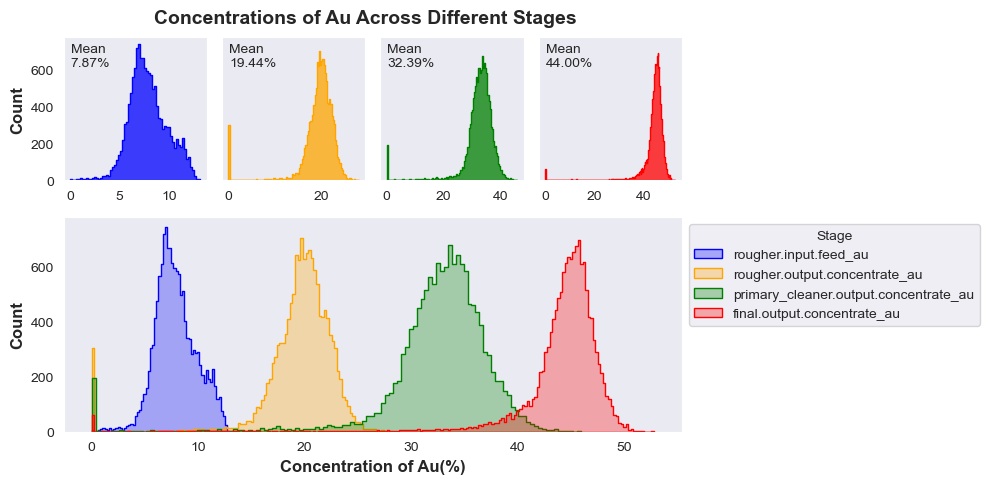

In [39]:
plot_stage_concentration(metal='au')

From the histograms,
- As expected, the concentration of gold (Au) increases gradually from the `rougher.input` stage (average 7.87%) to the `final.output` stage (average 44.00%).
- There are some anomalies of `0` at the `rougher.output`, `primary_cleaner.output` and `final.output` stages.

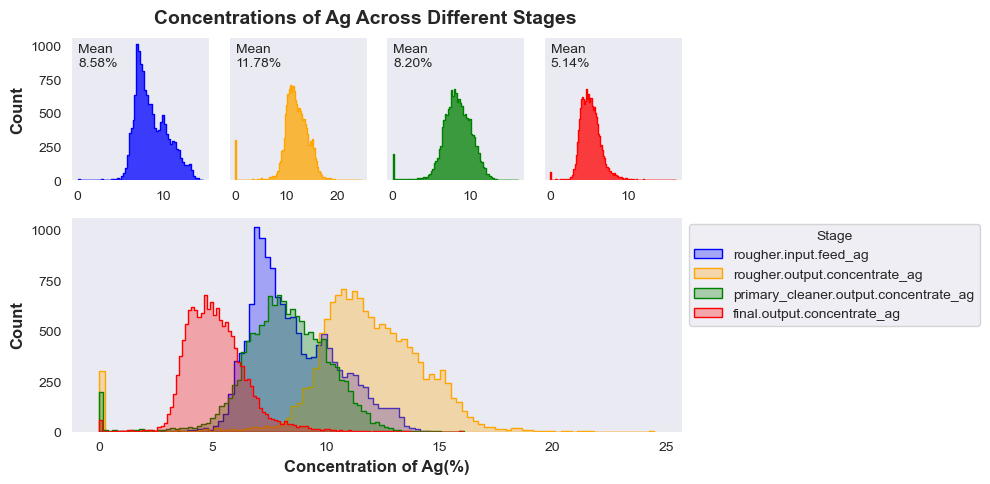

In [40]:
plot_stage_concentration(metal='ag')

From the histogram,
- The concentration of silver (Ag) is the highest at the `rougher.output` stage (average 11.78%) and slowly decrease.
- Similar to the distributions of concentrations of Au, there are anomalies of `0` at the second, third and fourth stages.

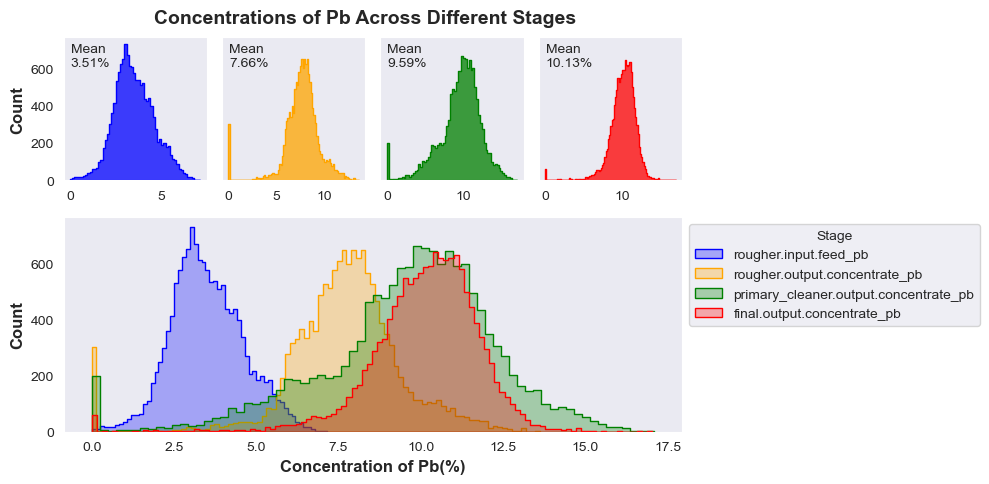

In [41]:
plot_stage_concentration(metal='pb')

From the histograms,
- The concentration of lead (Pb) decreases across the four stages.
- The anomalies of `0` also present in the last three stages.

[Back to Contents](#back)

### 4.2 The Distributions of the Feed Particle Size in The Training and Test Datasets <a id='particle_distribution'></a>

To ensure accurate model evaluation, it is crucial that the distributions of features in the `train data` and `test data` are similar. In the gold extraction process, the distributions of the feed particle size will affect the distributions of other features. Therefore, the distributions of feed particle size in the `test data` and `feed data` will be examined.

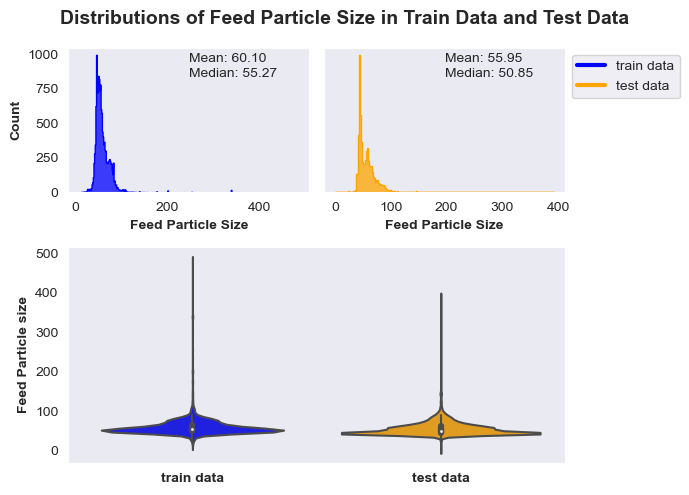

In [42]:
# Plot histograms and violinplots to examine if the distributions of
# feed particle sizes are similar in train data and test data

# Set up the figure
sns.set_style('dark')

layout = '''
    ab
    cc
'''

fig, axd = plt.subplot_mosaic(layout, height_ratios=[1.0, 1.5], figsize=(7,5))
fig.suptitle('Distributions of Feed Particle Size in Train Data and Test Data',
             fontsize=14, fontweight='bold')

# Extract the required data
train_particle = data['train']['rougher.input.feed_size']
test_particle = data['test']['rougher.input.feed_size']

# Plot the histograms and violinplot
sns.histplot(train_particle, color='blue', element='step', ax=axd['a'])
sns.histplot(test_particle, color='orange', element='step', ax=axd['b'])

sns.violinplot([train_particle, test_particle], palette=['blue', 'orange'], 
               label=['train data', 'test data'], ax=axd['c'])

axd['a'].set_xlabel('Feed Particle Size', fontweight='bold')
axd['a'].set_ylabel('Count', fontweight='bold')
axd['b'].set_xlabel('Feed Particle Size', fontweight='bold')
axd['b'].set_ylabel('')
axd['b'].set_yticks([])
axd['c'].set_xticks([0, 1], ['train data', 'test data'], fontweight='bold')
axd['c'].set_ylabel('Feed Particle size', fontweight='bold')

legend_labels = ['train data', 'test data']
legend_handles = [Line2D([0], [0], color='blue', lw=3), Line2D([0], [0], color='orange', lw=3)]
axd['b'].legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1,1))

# Display mean and median for train data and test data
axd['a'].text(0.5, 0.9, f'Mean: {train_particle.mean():.2f}', transform=axd['a'].transAxes)
axd['a'].text(0.5, 0.8, f'Median: {train_particle.median():.2f}', transform=axd['a'].transAxes)
axd['b'].text(0.5, 0.9, f'Mean: {test_particle.mean():.2f}', transform=axd['b'].transAxes)
axd['b'].text(0.5, 0.8, f'Median: {test_particle.median():.2f}', transform=axd['b'].transAxes)

plt.tight_layout()
plt.show()

From the violinplot, it can be seen that the distributions of the feed particle size in `train data` and `test data` are almost identical. The mean and median of `test data` is slightly less than those of the `train data`.

As the distributions does not vary significantly for both the `train data` and `test data`, the accuracy of the model can be assured.

[Back to Contents](#back)

### 4.3 Distributions of the Total Concentration of Metals at Different Stages <a id='total_concentration'></a>

In the section 4.1, we have discovered that the presence of anomalies `0` in the distributions of concentrations of metals. We shall investigate these anomalies as a whole by adding a column `total concentration` which sums them up.

In [43]:
# Find the total concentration of all metals
stages = ['rougher.input.feed', 'rougher.output.concentrate',
          'primary_cleaner.output.concentrate', 'final.output.concentrate']
metals = ['sol', 'au', 'au', 'pb']

for stage in stages:
    sum_metals = []
    for metal in metals:
        sum_metals.append(stage + '_' + metal)
    data['train'][stage + '_total'] = data['train'][sum_metals].sum(axis=1)

# Create a list to contain the column names of all total_concentrations
total_concentrations = ['rougher.input.feed_total', 'rougher.output.concentrate_total', 
                        'primary_cleaner.output.concentrate_total', 'final.output.concentrate_total']

# Have a look at the total_concentrations of all stages
data['train'][total_concentrations].head()

,rougher.input.feed_total,rougher.output.concentrate_total,primary_cleaner.output.concentrate_total,final.output.concentrate_total
0,52.065805,74.717987,98.267799,99.781013
1,50.976583,75.447820,98.103267,100.629984
2,50.855696,74.145209,97.461002,100.912755
3,51.136426,73.158514,80.996587,100.215291
4,47.461954,72.713430,95.276515,100.630209


The total concentration increases across the four stages as expected, let's investigate the anomalies of `0`.

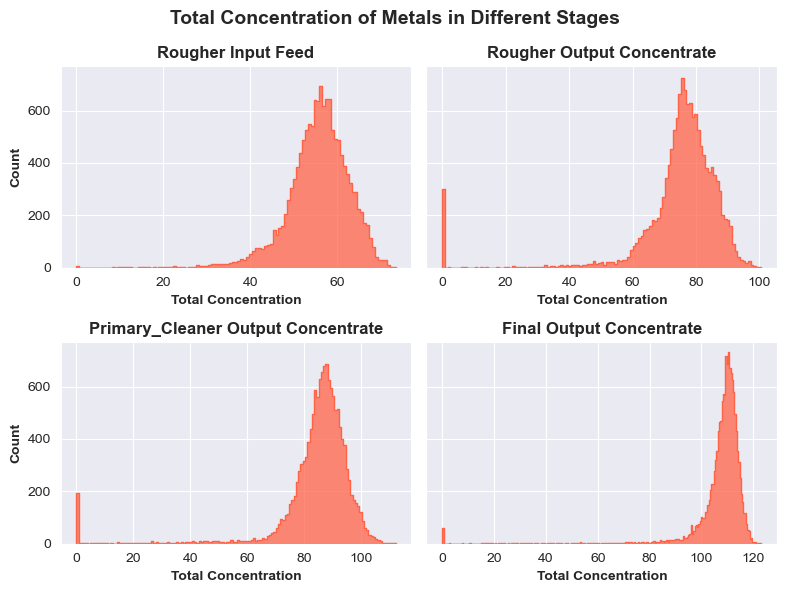

In [44]:
# Plot histograms to show the distributions of total concentration in four stages
plot_total_concentration(data['train'])

All the histograms show that there are anomalies of `0` in all the four stages. We will further look into the effect of these anomalies on the target values.

In [45]:
# Check the effect of anomalies on the target values
# Take the `rougher.output` stage as an example
anomalies_condition = data['train']['rougher.output.concentrate_total'] < 1

data['train'][anomalies_condition][
    ['rougher.output.concentrate_total', 'rougher.output.recovery', 'final.output.recovery']
]

,rougher.output.concentrate_total,rougher.output.recovery,final.output.recovery
45,0.00,0.0,68.403877
46,0.00,0.0,70.675633
47,0.00,0.0,55.088448
48,0.00,0.0,41.962008
50,0.00,0.0,49.884856
...,...,...,...
13035,0.04,100.0,100.000000
13036,0.04,100.0,100.000000
13037,0.04,100.0,100.000000
13038,0.04,100.0,100.000000


The table above shows two situations which should be classified as anomalies and considered to be removed before training the models.
1. In the row with index `45`, the `final.output.recovery` is 68.40 when the `rougher.output.concentrate_total` and the `rougher.output.recovery` are 0.
2. In the row with indexx `13038`, both the `rougher.output.recovery` and `final.output.recovery` are 100 when the `rougher.output.concentrate_total` is very small.

These two situations should be excluded from the `train data` as they may hinder the model to learn from proper cases. Nevertheless, we shall first calculate the percentages of these anomalies in each of the `total concentration` columns before dropping them.

In [46]:
# Create a dictionary to store the lower bound values for later use
anomalies_dict = {}

# Calculate the lower bound of anomalies in each stage and show the result
for concentration in total_concentrations:
    column = data['train'][concentration]
    total_anomalies = column[column < 1].shape[0]
    percentage_anomalies = f'{total_anomalies / column.shape[0]:.2%}'
    
    # print the result
    print('\033[1m')
    print('*' * 40)   
    print(concentration)    
    print('Number of anomalies:', total_anomalies)
    print('Percentage of anomalies', percentage_anomalies)
    print('*' * 40, '\n')   


****************************************
rougher.input.feed_total
Number of anomalies: 5
Percentage of anomalies 0.04%
**************************************** 


****************************************
rougher.output.concentrate_total
Number of anomalies: 302
Percentage of anomalies 2.13%
**************************************** 


****************************************
primary_cleaner.output.concentrate_total
Number of anomalies: 193
Percentage of anomalies 1.36%
**************************************** 


****************************************
final.output.concentrate_total
Number of anomalies: 59
Percentage of anomalies 0.42%
**************************************** 



The percentages of the anomalies in all stages are less than 2.13% and these anomalies will be dropped.

In [47]:
# Drop the anomalies where total concentration less than 1
for concentration in total_concentrations:
    data['train'] = data['train'][(data['train'][concentration] >= 1)]

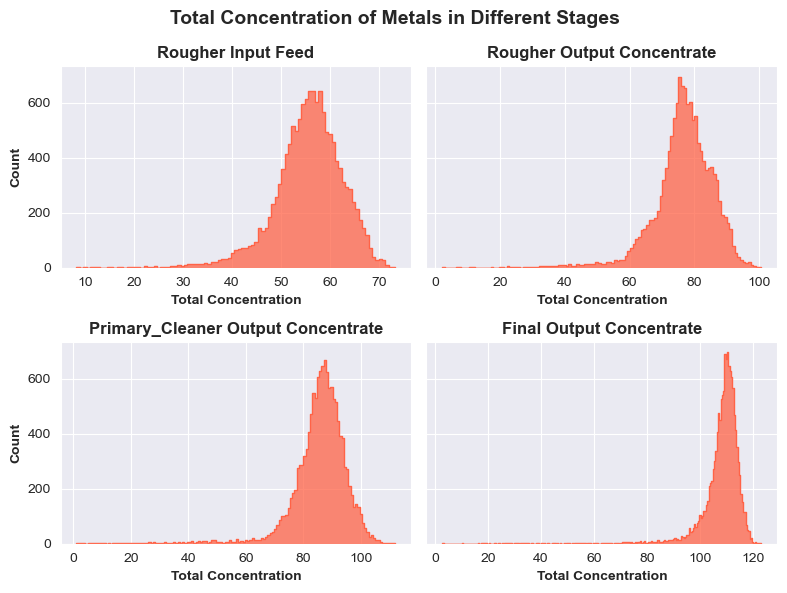

In [48]:
# Plot the histograms of total concentration to check if the anomalies have been dropped
plot_total_concentration(data['train'])

All the anomalies have been dropped.

[Back to Contents](#back)

### 4.4 Distributions of the Target Data <a id='target_distribution'></a>

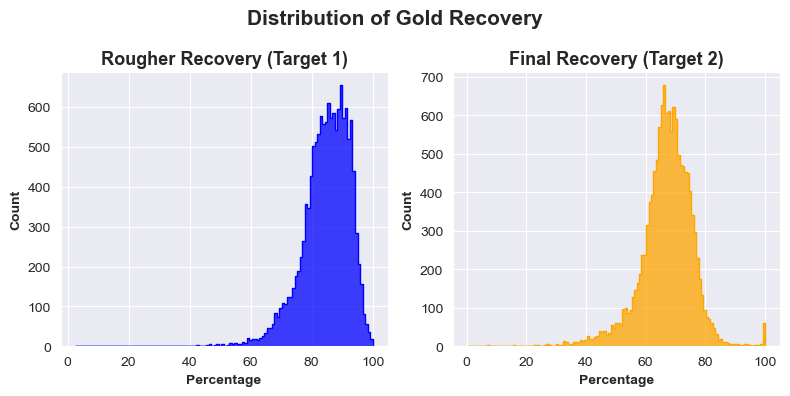

In [49]:
# Plot histograms to show the distribution of rougher recovery and rougher recovery
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

plt.suptitle('Distribution of Gold Recovery', fontsize=15, fontweight='bold')

sns.histplot(data['train']['rougher.output.recovery'], color='blue', 
             element='step', ax=ax1)
sns.histplot(data['train']['final.output.recovery'], color='orange', 
             element='step', ax=ax2)

ax1.set_title('Rougher Recovery (Target 1)', fontsize=13, fontweight='bold')
ax2.set_title('Final Recovery (Target 2)', fontsize=13, fontweight='bold')
ax1.set_xlabel('Percentage', fontweight='bold')
ax2.set_xlabel('Percentage', fontweight='bold')
ax1.set_ylabel('Count', fontweight='bold')
ax2.set_ylabel('Count', fontweight='bold')

plt.tight_layout()
plt.show()

The two targets have no anomalies, we are good to proceed to model training stage.

[Back to Contents](#back)

## 5. Development of Models <a id='models'></a>

---

The functions below will automate the tasks in this stage.

In [50]:
def calc_vif(X):
    '''
    This function calculates and return the
    variance inflation factor of each feature
    '''
    vif = pd.DataFrame()
    vif['features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values('VIF', ascending=False).reset_index(drop=True)
    
    return vif

In [51]:
def calc_correlation(X):
    '''
    This function calculates the coefficient of correlation
    between each pair of features and return a dataframe
    '''
    # Calculate the correlation matrix
    corr_matrix = X.corr()
    
    # Create a mask to select the upper triangle of the correlation matrix
    upper_tri_condition = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
    # Create a dataframe with the correlation values
    correlation_df = corr_matrix.where(upper_tri_condition)
    correlation_df = correlation_df.stack().sort_values(ascending=False).reset_index()
    correlation_df.columns = ['feature_1', 'feature_2', 'correlation']
    
    return correlation_df

In [52]:
def calc_sMAPE(y_true, y_pred):
    '''
    This function calculate and return the sMAPE of a model    
    '''
    n = len(y_true)
    abs_error = abs(y_true - y_pred)
    abs_sum_avg = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    sMAPE = (100 / n) * sum(abs_error / abs_sum_avg )
    
    return sMAPE

In [53]:
def calc_final_sMAPE(Y_true, Y_pred):
    '''
    This function calculates and returns the final sMAPE score    
    '''
    y_true_r, y_true_f = Y_true[:, 0], Y_true[:, 1]
    y_pred_r, y_pred_f = Y_pred[:, 0], Y_pred[:, 1]
    
    sMAPE_r = calc_sMAPE(y_true_r, y_pred_r)
    sMAPE_f = calc_sMAPE(y_true_f, y_pred_f)
    
    final_sMAPE = 0.25 * sMAPE_r + 0.75 * sMAPE_f
    
    return final_sMAPE

In [54]:
def test_models(model_dict, X_train, Y_train, evaluation_metric, cv):
    '''
    This function train and evaluate models 
    with a given evaluation metric by cross validation
    
    Return 
    '''
    model_names = []
    model_scores = []
    training_times = []
    
    for i, model in enumerate(model_dict):        
        start_time = time.time()       
        # Train and evaluate the model
        print(f'Training model {i + 1} of {len(model_dict)}: {model}')
        
        score = cross_val_score(model_dict[model], X_train, Y_train, cv=cv, 
                                scoring=evaluation_metric, n_jobs=-1)
        score = - score.mean()
        print(f'Final sMAPE: {score:.4f}\t', end='')
        
        model_names.append(model)
        model_scores.append(score)              
        end_time = time.time()        
        
        # Print the time taken
        time_taken = end_time - start_time
        minute = int(time_taken / 60)
        second = round(time_taken - minute * 60)
        
        if minute <= 1:
            training_time = f'{minute} minute {second} seconds'            
        else:
            training_time = f'{minute} minutes {second} seconds'        
        
        training_times.append(training_time)
        print('Time taken:', training_time, '\n')
    
    print('Finish training!')
    
    # Create a dataframe to store the result
    result_df = pd.DataFrame({
        'model': model_names,
        'final_sMAPE': model_scores,
        'training_time': training_times
    })
        
    result_df = result_df.sort_values('final_sMAPE').reset_index(drop=True)
    
    return result_df

In [55]:
def plot_model_result(data, figsize, xlim):
    '''
    This function plots a barchart to view the training result
    '''
    # Plot a barchart to view the result
    sns.set_style('white')
    plt.figure(figsize=figsize)
    colors = sns.color_palette('PuRd', n_colors=len(data))

    ax = sns.barplot(data=data, y='model', x='final_sMAPE', palette=colors)

    for i in ax.containers:
        ax.bar_label(i, fmt='%.4f')
    ax.set_title('Final sMAPE Score of Models', 
                 fontsize=14, fontweight='bold', y=1.02)
    ax.set_xlabel('Final sMAPE (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Model', fontsize=12, fontweight='bold')
    ax.set_xlim(xlim)
    plt.show()

In [56]:
def plot_model_result(data, figsize, xlim):
    '''
    This function plots a barchart to view the training result
    '''
    # Set up the figure
    sns.set_style('white')
    plt.figure(figsize=figsize)
    colors = sns.color_palette('PuRd', n_colors=len(data))
    
    # Plot the barchart
    ax = sns.barplot(data=data, y='model', x='final_sMAPE', palette=colors)
    
    for i in ax.containers:
        ax.bar_label(i, fmt='%.4f')
    ax.set_title('Final sMAPE Score of Models', 
                 fontsize=14, fontweight='bold', y=1.02)
    ax.set_xlabel('Final sMAPE (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Model', fontsize=12, fontweight='bold')
    ax.set_xlim(xlim)
    plt.show()

---

### 5.1 Separate the Data into Features and Targets <a id='feature_target'></a>

In [57]:
# Drop the calculation and measurement features in train data
data['train'] = data['train'][data['test'].columns]

In [58]:
# Check the first 3 rows of each dataset
display(data['train'].head(3))
display(data['train'].head(3))

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,70.541216
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,69.266198
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,68.116445


,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763,70.541216
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594,1000.286398,-400.065196,1600.754587,-449.953435,1600.479580,-449.830646,1600.527589,-449.953649,1399.227084,-450.869848,1399.719514,-450.119001,25.880539,-499.989656,23.889530,-500.372428,23.970550,-500.085473,22.085714,-499.446897,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261,69.266198
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,1599.541515,-499.827444,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,999.719565,-400.074028,1599.337330,-450.008530,1599.672797,-449.954491,1599.849325,-449.954185,1399.180945,-449.937588,1400.316682,-450.527147,26.005245,-499.929616,23.886657,-499.951928,23.913535,-499.442343,23.957717,-499.901982,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308,68.116445


In [59]:
# Get the features and targets
X_train = data['train'].drop(columns=['date', 'rougher.output.recovery', 'final.output.recovery'])
Y_train = data['train'][['rougher.output.recovery', 'final.output.recovery']].values

X_test = data['test'].drop(columns=['date', 'rougher.output.recovery', 'final.output.recovery'])
Y_test = data['test'][['rougher.output.recovery', 'final.output.recovery']].values

[Back to Contents](#back)

### 5.2 Feature Selection <a id='feature_selection'></a>

In the data exploration stage, we have seen that there are many features (columns) are similar in name. It is suspected that the features are highly correlated and multicollinearity exists. The existence of multicollinearity have little impact on the model predictive performance. However, by reducing the features, the training time can be improved and model can choose the right predictors easier.

To detect the presence of multicollinearity, the variance inflation factor (VIF) and coefficient of correlation will be calculated.

In [60]:
# Calculate the variance inflation factors of X_train and X_test
print('\033[1m', 'Top five features with the highest VIF in X_train')
display(calc_vif(X_train).head())
print('*' * 50)
print('\033[1m', 'Top five features with the highest VIF in X_test')
display(calc_vif(X_test).head())

 Top five features with the highest VIF in X_train


,features,VIF
0,rougher.state.floatbank10_c_level,7561.868405
1,primary_cleaner.state.floatbank8_b_level,6620.218403
2,primary_cleaner.state.floatbank8_a_level,5782.500550
3,rougher.state.floatbank10_e_level,5344.572598
4,rougher.state.floatbank10_f_level,3905.830377


**************************************************
 Top five features with the highest VIF in X_test


,features,VIF
0,rougher.state.floatbank10_c_level,6819.992667
1,primary_cleaner.state.floatbank8_b_air,6556.574742
2,rougher.state.floatbank10_b_level,5600.210966
3,primary_cleaner.state.floatbank8_a_air,4980.120651
4,primary_cleaner.state.floatbank8_d_air,3689.303241


The strength of VIF can be classified as follows:
- A VIF of 1 indicates no correlation between the variable and the other variables.
- A VIF between 1 and 5 suggests moderate correlation, and it is generally considered acceptable.
- A VIF greater than 5 indicates high correlation, and values above 10 are often a cause for concern, as they suggest a potentially problematic level of multicollinearity.

The above two tables show an extremely high values of VIF and this infers that the multicollineary exists. Next, we will find which pairs of features are correlated by calculating the the coefficients of correlation between features. The pair of features with correlation higher than 0.7 will be considered to dropped.

In [61]:
# Calculate the correlation
X_train_corr = calc_correlation(X_train)
X_test_corr = calc_correlation(X_test)

In [62]:
# Show the pair of features with correlation higher than 0.7
print('\033[1m', 'Pairs of features with correlation higher than 0.7 in X_train')
display(X_train_corr.query('correlation > 0.7'))
print('*' * 80)
print('\033[1m', 'Pairs of features with correlation higher than 0.7 in X_test')
display(X_test_corr.query('correlation > 0.7'))

 Pairs of features with correlation higher than 0.7 in X_train


,feature_1,feature_2,correlation
0,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_level,0.989678
1,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_level,0.987628
2,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_level,0.987575
3,rougher.state.floatbank10_c_level,rougher.state.floatbank10_e_level,0.984816
4,rougher.state.floatbank10_b_level,rougher.state.floatbank10_d_level,0.977652
5,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_level,0.977623
6,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_level,0.977400
7,rougher.state.floatbank10_c_level,rougher.state.floatbank10_f_level,0.977321
8,rougher.state.floatbank10_d_level,rougher.state.floatbank10_f_level,0.975084
9,rougher.state.floatbank10_b_level,rougher.state.floatbank10_e_level,0.973716


********************************************************************************
 Pairs of features with correlation higher than 0.7 in X_test


,feature_1,feature_2,correlation
0,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_level,0.986990
1,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_d_air,0.974342
2,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_b_air,0.968679
3,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_level,0.963408
4,rougher.state.floatbank10_b_air,rougher.state.floatbank10_c_air,0.962024
5,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_d_air,0.959166
6,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_level,0.955387
7,rougher.state.floatbank10_c_air,rougher.state.floatbank10_d_air,0.950722
8,rougher.state.floatbank10_b_level,rougher.state.floatbank10_d_level,0.945441
9,rougher.state.floatbank10_b_air,rougher.state.floatbank10_d_air,0.931076


By observing the two tables above, those pairs of features with correlation higher than 0.7 mostly have the same suffix, for example the highest correlation pair in `X_train` is `rougher.state.floatbank10_e_level` and `rougher.state.floatbank10_e_level`. Therefore, the features with names containing `_b_`, `_c_`, `_d_`, `_e_`, `_f_` will be dropped.

In [63]:
# Create a list containing features to be dropped
drop_features = []

for feature in data['train'].columns:
    if '_b_' in feature or '_c_' in feature or '_d_' in feature \
    or '_e_' in feature or '_f_' in feature:
        drop_features.append(feature)

# Show the number of features before and after dropping features
print(f'A total of {len(drop_features)} features will be dropped.')
print('Number of feature before dropping:', X_train.shape[1])
print('Number of feature after dropping:', X_train.shape[1] - len(drop_features))

A total of 24 features will be dropped.
Number of feature before dropping: 52
Number of feature after dropping: 28


In [64]:
# Drop the features in X_train and X_test
X_train.drop(columns=drop_features, inplace=True)
X_test.drop(columns=drop_features, inplace=True)

In [65]:
# Check the VIF after dropping the features
print('\033[1m', 'Top five features with the highest VIF in X_train')
display(calc_vif(X_train).head())
print('*' * 50)
print('\033[1m', 'Top five features with the highest VIF in X_test')
display(calc_vif(X_test).head())

 Top five features with the highest VIF in X_train


,features,VIF
0,secondary_cleaner.state.floatbank5_a_level,677.944786
1,secondary_cleaner.state.floatbank4_a_level,369.554726
2,rougher.input.floatbank10_xanthate,306.271855
3,secondary_cleaner.state.floatbank6_a_level,282.347445
4,rougher.input.floatbank11_xanthate,265.543553


**************************************************
 Top five features with the highest VIF in X_test


,features,VIF
0,secondary_cleaner.state.floatbank5_a_level,977.013745
1,rougher.input.floatbank11_xanthate,780.048215
2,rougher.input.floatbank10_xanthate,700.179563
3,primary_cleaner.state.floatbank8_a_level,699.608823
4,rougher.input.floatbank10_sulfate,558.743511


The VIFs are still high but improve a lot.

In [66]:
# Calculate the correlation after dropping features
X_train_corr2 = calc_correlation(X_train)
X_test_corr2 = calc_correlation(X_test)

# Show the pair of features with correlation higher than 0.7
print('\033[1m', 'Pairs of features with correlation higher than 0.7 in X_train')
display(X_train_corr2.query('correlation > 0.7'))
print('*' * 80)
print('\033[1m', 'Pairs of features with correlation higher than 0.7 in X_train')
display(X_test_corr2.query('correlation > 0.7'))

 Pairs of features with correlation higher than 0.7 in X_train


,feature_1,feature_2,correlation
0,rougher.input.feed_ag,rougher.input.feed_au,0.846780
1,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_xanthate,0.841082
2,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank5_a_level,0.795777
3,rougher.input.floatbank10_sulfate,rougher.input.floatbank11_sulfate,0.787859
4,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank5_a_air,0.774420
5,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank4_a_level,0.726331
6,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank5_a_air,0.711707


********************************************************************************
 Pairs of features with correlation higher than 0.7 in X_train


,feature_1,feature_2,correlation
0,rougher.input.floatbank10_sulfate,rougher.input.floatbank11_sulfate,0.921599
1,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_xanthate,0.863760
2,rougher.input.feed_ag,rougher.input.feed_au,0.859775
3,rougher.input.feed_rate,rougher.input.feed_sol,0.766421


After dropping the 24 features, there are only 7 and 4 pairs of features with correlations higher than 0.7.

*Note: The overalll performance of models are almost the same after dropping the features but the training time is improved by at least 30%. (Screenshot is shown in the Appendix)*

[Back to Contents](#back)

### 5.3 Feature Scaling <a id='feature_scaling'></a>

Standarisation will be performed on the features since the range of values of features are of different scales.

In [67]:
# Perform standardisation on the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [68]:
# Check the shapes of training set and test set
print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', Y_train.shape)

print('Shape of X_test:', X_test.shape)
print('Shape of Y_test:', Y_test.shape)

Shape of X_train: (13600, 28)
Shape of Y_train: (13600, 2)
Shape of X_test: (5290, 28)
Shape of Y_test: (5290, 2)


[Back to Contents](#back)

### 5.4 Training Different Models <a id='train_models'></a>

To evaluate the model performance which based on time series data, the evaluation metric `sMAPE` (symmetric mean absolute percentage error) will be used. The formula of `sMAPE` is given by

$$\text{sMAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \frac{|y_{i} - \hat{y}|}{\frac {(|y_i| + |\hat{y}|)}{2}}$$

The metric sMAPE has a range of 0% to 200%, where lower values indicate better accuracy. It is symmetric because it considers the symmetric percentage error between the predicted and the actual values, making it insensitive to the scale of the time series.

Since there are two targets, the final evaluation metric will based on the following formula:

$$\text{Final sMAPE} = 25\% \times \text{sMAPE}_{\text{rougher}} + 75\% \times \text{sMAPE}_{\text{final}}$$

To find a good model to predict the targets, a number of different models will be trained first without tuning the hyperparameters. Then, three models will be selected to fine tune the hyperparameters.

In [69]:
# Create a dictionary to store models
models = {}

# Models to be tested without hyperparameter tuning
models['Baseline'] = DummyRegressor(strategy='mean')
models['Decision Tree'] = DecisionTreeRegressor(random_state=12345)
models['Linear Regression'] = LinearRegression()
models['Lasso'] = Lasso()
models['Ridge'] = Ridge()
models['Elastic Net'] = ElasticNet()
models['SGD Regressor'] = MultiOutputRegressor(SGDRegressor())
models['Linear SVM'] = MultiOutputRegressor(SVR(kernel='linear'))
models['Non-Linear SVM'] = MultiOutputRegressor(SVR(kernel='rbf'))
models['KNN'] = KNeighborsRegressor()
models['XGBoost'] = XGBRegressor()
models['Adaboost'] = MultiOutputRegressor(AdaBoostRegressor())
models['LightGBM'] = MultiOutputRegressor(LGBMRegressor())
models['CatBoost'] = MultiOutputRegressor(CatBoostRegressor(verbose=0))
models['Gradient Boost'] = MultiOutputRegressor(GradientBoostingRegressor())
models['Random Forest'] = RandomForestRegressor(random_state=12345)

In [70]:
# Evaluation metric: sMAPE
final_sMAPE_score = make_scorer(calc_final_sMAPE, greater_is_better=False)

# Train the models
model_result = test_models(
    model_dict = models,
    X_train = X_train, 
    Y_train = Y_train,
    evaluation_metric = final_sMAPE_score,
    cv = 5
)

Training model 1 of 16: Baseline
Final sMAPE: 9.6435	Time taken: 0 minute 2 seconds 

Training model 2 of 16: Decision Tree
Final sMAPE: 13.7496	Time taken: 0 minute 2 seconds 

Training model 3 of 16: Linear Regression
Final sMAPE: 9.7434	Time taken: 0 minute 0 seconds 

Training model 4 of 16: Lasso
Final sMAPE: 8.5818	Time taken: 0 minute 0 seconds 

Training model 5 of 16: Ridge
Final sMAPE: 9.7416	Time taken: 0 minute 0 seconds 

Training model 6 of 16: Elastic Net
Final sMAPE: 8.3985	Time taken: 0 minute 0 seconds 

Training model 7 of 16: SGD Regressor
Final sMAPE: 9.8375	Time taken: 0 minute 0 seconds 

Training model 8 of 16: Linear SVM
Final sMAPE: 9.4987	Time taken: 0 minute 29 seconds 

Training model 9 of 16: Non-Linear SVM
Final sMAPE: 8.5686	Time taken: 0 minute 28 seconds 

Training model 10 of 16: KNN
Final sMAPE: 10.5125	Time taken: 0 minute 0 seconds 

Training model 11 of 16: XGBoost
Final sMAPE: 9.1396	Time taken: 0 minute 3 seconds 

Training model 12 of 16: Adabo

In [71]:
# Have a look at the result
model_result

,model,final_sMAPE,training_time
0,CatBoost,8.201420,0 minute 34 seconds
1,Elastic Net,8.398523,0 minute 0 seconds
2,Non-Linear SVM,8.568582,0 minute 28 seconds
3,Lasso,8.581761,0 minute 0 seconds
4,LightGBM,8.725678,0 minute 3 seconds
5,Gradient Boost,8.781115,1 minute 1 seconds
6,Random Forest,8.998984,1 minute 59 seconds
7,Adaboost,9.107676,0 minute 8 seconds
8,XGBoost,9.139599,0 minute 3 seconds
9,Linear SVM,9.498674,0 minute 29 seconds


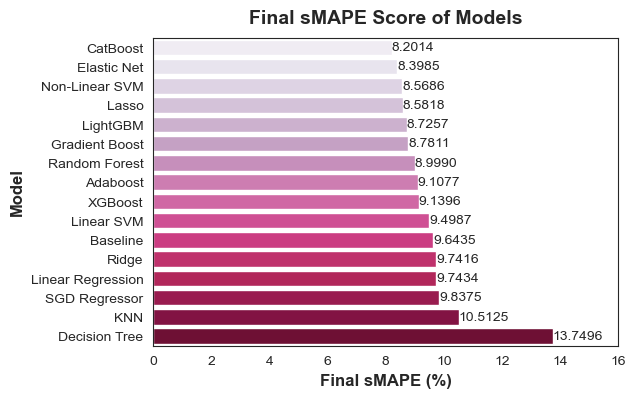

In [72]:
# Plot a barchart to view the result
plot_model_result(data=model_result, figsize=(6,4), xlim=(0,16))

Without hyperparameter tuning, the top three models are `CatBoost`, `Elastic Net` and `Non-Linear SVM`. There are ten models better than the baseline model while another five models are underperformed.

The following three models are selected to fine-tune the hyperparameters:
1. `Elastic Net`: The best model among the six linear models (`Linear Regression`, `Elastic Net`, `Lasso`, `Ridge`, `SGD Regressor`, `Linear SVM`)
2. `Non-Linear SVM`: This model ranked at the third without any hyperparameter fine-tuning but the training time is relatively lengthy. 
3. `Light GBM`: All the boosting ensemble models (`CatBoost`, `LightGBM`, `Gradient Boost`, `XGBoost`, `AdaBoost`) have similar performances. Since there are a lot of hyperparameters needs to be tuned for a boosting ensemble, the `LightGBM` model with the shortest training time is chosen.

[Back to Contents](#back)

### 5.5 Fine-tuning Selected Models <a id='fine_tune_models'></a>

In [73]:
# Create a dictionary to store the fine-tuned score
fine_tuned_sMAPE = {}

#### Tuning the Hyperparameters of Elastic Net

The following hyperparameters will be tuned for the elastic net model:
- `alpha`: The constant which multiplies on the L1 (Lasso) and L2 (Ridge) regularisation terms. Both L1 and L2 regularisation penalise large weights on the features. However, L1 regularisation encourages the sparsity in the features (the weight can be zero) while L2 regularisation does not enforce sparsity.
- `l1_ratio`: This hyperparameter controls the ratio of L1 and L2 regularisation.

In [74]:
%%time
# Setting up the grid search
enet = ElasticNet()

enet_hyperparameters = [
    {'alpha': [0.01, 0.1, 1, 10, 100],
     'l1_ratio': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0]}
]

# Start the grid search
enet_grid = GridSearchCV(estimator = enet,
                         param_grid = enet_hyperparameters,
                         scoring = final_sMAPE_score,
                         cv = 5,
                         n_jobs = -1)
enet_grid.fit(X_train, Y_train)

CPU times: total: 1.34 s
Wall time: 3.14 s


GridSearchCV(cv=5, estimator=ElasticNet(), n_jobs=-1,
             param_grid=[{'alpha': [0.01, 0.1, 1, 10, 100],
                          'l1_ratio': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75,
                                       1.0]}],
             scoring=make_scorer(calc_final_sMAPE, greater_is_better=False))

In [75]:
# Store the result
models['Fine-tuned Elastic Net'] = enet_grid.best_estimator_
fine_tuned_sMAPE['Fine-tuned Elastic Net'] = - enet_grid.best_score_ # sMAPE is negative since
                                                                     # greater_is_better=False
# Show the result
print('The hyperparameters of the fine-tuned elastic net')
print(enet_grid.best_params_)
print()
print('The final sMAPE score of the fine-tuned elastic net: ', end='')
print(f'{fine_tuned_sMAPE["Fine-tuned Elastic Net"]:.2f}')

The hyperparameters of the fine-tuned elastic net
{'alpha': 1, 'l1_ratio': 0.25}

The final sMAPE score of the fine-tuned elastic net: 8.38


#### Tuning the Hyperparameters of Non-linear SVM

The following hyperparameters will be tuned for the Non-linear SVM model:
- `C`: The regularisation term which controls the margin of the decision boundary. The lower the value, the larger the margin and the model is less prone to overfitting.
- `gamma`: This parameter controls the shape of the decision boundary. The lower the value, the 'smoother' the boundary and the model is less prone to overfitting.

In [76]:
%%time
# Setting up the grid search
svm = MultiOutputRegressor(SVR())

svm_hyperparameters = [
    {'estimator__kernel': ['rbf'],
     'estimator__C': [0.01, 0.1, 1],
     'estimator__gamma': [0.01, 0.1, 1]}
]

# Start the grid search
svm_grid = GridSearchCV(estimator = svm,
                        param_grid = svm_hyperparameters,
                        scoring = final_sMAPE_score,
                        cv = 5,
                        n_jobs = -1)
svm_grid.fit(X_train, Y_train)

CPU times: total: 17.2 s
Wall time: 4min 41s


GridSearchCV(cv=5, estimator=MultiOutputRegressor(estimator=SVR()), n_jobs=-1,
             param_grid=[{'estimator__C': [0.01, 0.1, 1],
                          'estimator__gamma': [0.01, 0.1, 1],
                          'estimator__kernel': ['rbf']}],
             scoring=make_scorer(calc_final_sMAPE, greater_is_better=False))

In [77]:
# Store the result
models['Fine-tuned Non-Linear SVM'] = svm_grid.best_estimator_
fine_tuned_sMAPE['Fine-tuned Non-Linear SVM'] = - svm_grid.best_score_

# Show the result
print('The hyperparameters of the fine-tuned non-linear svm')
print(svm_grid.best_params_)
print()
print('The final sMAPE score of the fine-tuned non-linear svm: ', end='')
print(f'{fine_tuned_sMAPE["Fine-tuned Non-Linear SVM"]:.2f}')

The hyperparameters of the fine-tuned non-linear svm
{'estimator__C': 0.1, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}

The final sMAPE score of the fine-tuned non-linear svm: 8.34


#### Tuning the Hyperparameters of LightGBM

The following hyperparameters will be tuned for the LightGBM model:
- `num_leaves`: The complexity of the model increases with the number of leaves. Therefore, a high number of leaves may lead to overfitting.
- `max_depth`: Same as the `num_leaves` parameter, the higher the number, the higher the chance of being overfitting.
- `n_estimators`: This parameter decides how many trees will be trained. This number should be large enough to reduce the variance. However, it is computational expensive for a large number of trees. 
- `learning_rate`: This parameter control the step size during the optimisation process. A small value may not find the optimised value if the number of trees is not large enough. A large value speeds up the training speed but may overshoot the optimised value.
- `reg_alpha`: The L1 regularisation.
- `reg_lambda`: The L2 regularisation.
- `subsample`: The fraction of rows used in the tree. Prevent the model from being overfitting. Low value can improve the training speed.
- `colsample_bytree`: The fraction of features used in the tree. Prevent the model from being overfitting. Low value can improve the training speed.

Since there are many hyperparameters to be tuned, we will use the optuna library to search for the best possible model. In Optuna, the Tree-stuctured Parzen Estimator (TPE) algorithm can be used for sampling hyperparameters during the optimisation process. The TPE algorithm is a Bayesian optimization method which uses a probability distribution to guide the search for optimal hyperparameters.

In [78]:
# Define the objective function of a study
def lgbm_objective(trial):
    # Set up the search space       
    lgbm_hyperparameters = {
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'max_depth': trial.suggest_int('max_depth', 3, 7),     
        'n_estimators': trial.suggest_int('n_estimators', 20, 70, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1e2, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6)        
    }
    
    # Train and evaluate the model    
    lgbm = MultiOutputRegressor(LGBMRegressor(**lgbm_hyperparameters))
    final_sMAPE = cross_val_score(lgbm, X_train, Y_train, scoring=final_sMAPE_score,
                                  cv=5, n_jobs=-1)
    final_sMAPE = final_sMAPE.mean()
    
    return final_sMAPE

In [79]:
%%time
# Set up the study
optuna.logging.set_verbosity(optuna.logging.WARNING)
lgbm_study = optuna.create_study(sampler = TPESampler(seed=12345), # for reproducible result                                 
                                 study_name = 'lgbm',
                                 direction = 'maximize') # sMAPE is negative
                                                         # Maximise negative value means minimise positive value

# Search for the LightGBM model with best possible score in 100 trials
lgbm_study.optimize(lgbm_objective, n_trials=100)

CPU times: total: 4.88 s
Wall time: 52.9 s


In [80]:
# Store the result
models['Fine-tuned LightGBM'] = MultiOutputRegressor(LGBMRegressor(**lgbm_study.best_params, verbose=-1))
fine_tuned_sMAPE['Fine-tuned LightGBM'] = - lgbm_study.best_value

# Show the result
print('The hyperparameters of the fine-tuned LightGBM')
print(lgbm_study.best_params)
print()
print('The final sMAPE score of the fine-tuned LightGBM: ', end='')
print(f'{fine_tuned_sMAPE["Fine-tuned LightGBM"]:.2f}')

The hyperparameters of the fine-tuned LightGBM
{'num_leaves': 16, 'max_depth': 4, 'n_estimators': 70, 'learning_rate': 0.03494372491789759, 'reg_alpha': 71.19836326479353, 'reg_lambda': 0.05965689204136831, 'subsample': 0.6589591705893987, 'colsample_bytree': 0.5179751092412022}

The final sMAPE score of the fine-tuned LightGBM: 7.98


In [81]:
# Store the fine-tuned result in the model_result df
for model, score in fine_tuned_sMAPE.items():
    row = pd.DataFrame({'model': [model], 'final_sMAPE': [score]})
    model_result = pd.concat([model_result, row])

In [82]:
# Show the final result
model_result = model_result.sort_values('final_sMAPE').reset_index(drop=True)
model_result

,model,final_sMAPE,training_time
0,Fine-tuned LightGBM,7.984752,NaN
1,CatBoost,8.201420,0 minute 34 seconds
2,Fine-tuned Non-Linear SVM,8.336549,NaN
3,Fine-tuned Elastic Net,8.375433,NaN
4,Elastic Net,8.398523,0 minute 0 seconds
5,Non-Linear SVM,8.568582,0 minute 28 seconds
6,Lasso,8.581761,0 minute 0 seconds
7,LightGBM,8.725678,0 minute 3 seconds
8,Gradient Boost,8.781115,1 minute 1 seconds
9,Random Forest,8.998984,1 minute 59 seconds


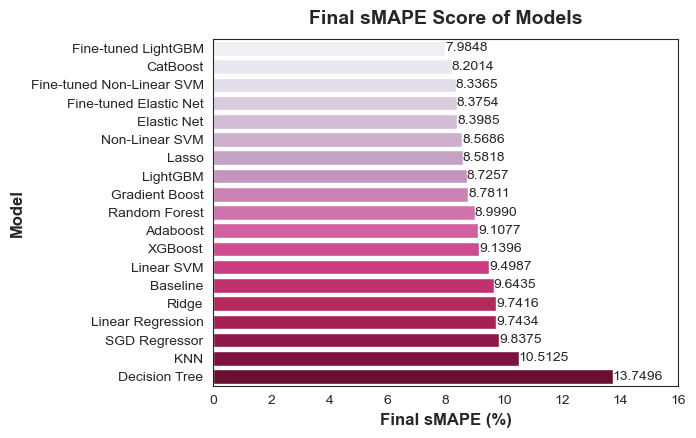

In [83]:
plot_model_result(data=model_result, figsize=(6,4.5), xlim=(0,16))

**After the fine-tuning of hyperparameters, the `Fine-tuned LightGBM` has the best `final sMAPE` score of 7.98% and will be selected as the final model.**

### 5.6 Evaluation of the Final Model on the Test Set <a id='final_model'></a>

In [84]:
# Assign the final model
final_model = models['Fine-tuned LightGBM']

# Train and evaluate the final model on the test set
final_model.fit(X_train, Y_train)

Y_pred_final = final_model.predict(X_test)
final_model_score = calc_final_sMAPE(Y_test, Y_pred_final)

# Print the final sMAPE score of the final model
print('The final sMAPE score of the fine-tuned LGBM on the test set is ', end='')
print(f'{final_model_score:.2f}%')

The final sMAPE score of the fine-tuned LGBM on the test set is 8.73%


**The final sMAPE score of the fine-tuned LGBM on the test set is 8.73%.**

**Sanity Check with the Baseline Model**

In [85]:
# Train and evaluate the baseline on the test set
models['Baseline'].fit(X_train, Y_train)

Y_pred_baseline = models['Baseline'].predict(X_test)
baseline_model_score = calc_final_sMAPE(Y_test, Y_pred_baseline)

# Print the final sMAPE score of the final model
print('The final sMAPE score of the baseline model on the test set is ', end='')
print(f'{baseline_model_score:.2f}%')

# Compare the two models
improvement = baseline_model_score - final_model_score
percentage_improvement = improvement / baseline_model_score
print(f'The sMAPE score of fine-tuned LightGBM is {percentage_improvement:.2%} \
better than the baseline model.')

The final sMAPE score of the baseline model on the test set is 9.83%
The sMAPE score of fine-tuned LightGBM is 11.20% better than the baseline model.


**The baseline model has a final sMAPE score of 9.83% on the test set. 
The fined-tuned LightGBM outperforms the baseline model by 11.20% on the test set.**

[Back to Contents](#back)

## 6.0 General Conclusion <a id='general_conclusion'></a>
**Data Exploration**

The Zyfra company has provided us three datasets, `full data`, `train data` and `test data`. The `train data` and `test data` are from the `full data`. There are 87 columns in `full data` and `train data` while the `test data` has 34 columns less. After exploring the dataset, there are some issues need to be adressed.
- The data type of `date` in the three datasets are incorrect.
- A huge amount of missing values present especially the missing values in the targets `rougher.output.recovery` and `final.output.recovery` need further investigation.
4. The range of values of the features are of different scales thus standardisation will be carried out.

**Data Preprocessing**

- The data type of `date` has been converted to datetime.
- The target values provided by the company are correct.
- The missing columns in the `test data` are the calculation or measurement columns which will not be used in the model building. These columns will be dropped from the `train data`.

**Exploratory Data Analysis**

- The concentration of `au` increases across four stages while the concentration of `pb` and `ag` generally decrease across stages.
- The distributions of feed particles in `train data` and `test data` are highly similar. This ensures accurate model evaluation in the later stage.
- Anomalies of `0` present in the total concentration of all stages. These anomalies are dropped from the `train data` so that the models can learn from proper cases.
- The distributions of targets in `train data` and `test data` shows no anomalies.

**Development of Models**

- After the evaluation of VIF and correlations of features, the presence of multicollinearity is identified. A total of 24 features are dropped.
- Standardisation of features is performed.
- A total of 16 models (including a baseline model) without hyperparameter tuning are trained. 
- Among the ten models which outperform the baseline models, `Elastic Net`, `Non-Linear SVM` and `LightGBM` models are chosen to fine-tune their hyperparameters.

**After the fine-tuning of hyperparameters, the Fine-tuned LightGBM has the best final sMAPE score of 7.98% and will be selected as the final model.**

**The final sMAPE score of the fine-tuned LGBM on the test set is 8.73%. The baseline model has a final sMAPE score of 9.83% on the test set. The fined-tuned LightGBM outperforms the baseline model by 11.20% on the test set.**

[Back to Contents](#back)

## 7. Appendix <a id='appendix'></a>

The overalll performance of models are almost the same after dropping the features but the training time is improved by at least 30%.

![final_sMAPE](https://raw.githubusercontent.com/chongwee0312/tripleten_datascience_projects/main/project_09/images/sMAPE_compare.png)

![table_comparison](https://raw.githubusercontent.com/chongwee0312/tripleten_datascience_projects/main/project_09/images/table_compare.png)

[Back to Contents](#back)